In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline

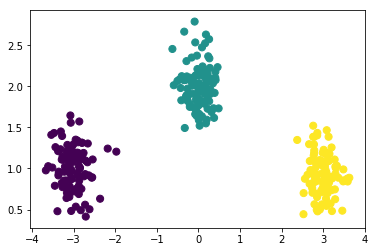

In [2]:
# Create the  training data
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

In [3]:
num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
num_classes = 3

In [4]:
for j in range(num_classes):
    empty_v = np.zeros(num_classes * num_inFeatures)
    empty_v[(j*num_inFeatures):(j+1)*num_inFeatures] = X[0]
    print(empty_v)

[-2.90738887  1.33990847  0.          0.          0.          0.        ]
[ 0.          0.         -2.90738887  1.33990847  0.          0.        ]
[ 0.          0.          0.          0.         -2.90738887  1.33990847]


In [5]:
def featureMap(X,y,num_classes) :
    #class sensitive feature mapping
    '''
    Computes the class-sensitive features.
    @param X: array-like, shape = [n_samples,n_inFeatures] 
                or [n_inFeatures,], input features for input data
    @param y: a target class (in range 0,..,num_classes-1)
    @return array-like, shape = [n_samples,n_outFeatures], 
                        the class sensitive features for class y
    '''
    #The following line handles X being a 1d-array or a 2d-array
    num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
    X_new = np.tile(A = X,reps=num_classes)      
    return X_new

X_new = featureMap(X,y,num_classes = 3)
X_new

array([[-2.90738887,  1.33990847, -2.90738887,  1.33990847, -2.90738887,
         1.33990847],
       [ 2.83555791,  0.6871379 ,  2.83555791,  0.6871379 ,  2.83555791,
         0.6871379 ],
       [ 2.85131938,  0.92129704,  2.85131938,  0.92129704,  2.85131938,
         0.92129704],
       ..., 
       [-2.74990853,  0.90472687, -2.74990853,  0.90472687, -2.74990853,
         0.90472687],
       [-0.28917479,  2.30850867, -0.28917479,  2.30850867, -0.28917479,
         2.30850867],
       [-3.11355696,  1.12859268, -3.11355696,  1.12859268, -3.11355696,
         1.12859268]])

In [6]:
def sgd(X, y, num_outFeatures, subgd, eta = 0.05, T = 10000):
    w_vec = np.zeros(num_outFeatures)
    w_updates = [w_vec]
    num_samples = X.shape[0]
    m_svm = MulticlassSVM(6)
    for num_iter in range(T):
        for i in range(num_samples):
            grad = m_svm.subgradient(X[i],y[i],w_vec)
            w_vec = w_vec - eta*grad
        w = w_vec
        w_updates.append(w)
    w_fin = np.zeros((num_outFeatures))
    w_updates = np.vstack((w_updates))
    for a in range(len(w_fin)):
        w_fin[a] = np.mean(w_updates[:,a])
    return np.array(w_fin)

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone

def zeroOne(y,a) :
    '''
    Computes the zero-one loss.
    @param y: output class
    @param a: predicted class
    @return 1 if different, 0 if same
    '''
    return int(y != a)

def featureMap(X,y,num_classes) :
    #class sensitive feature mapping
    '''
    Computes the class-sensitive features.
    @param X: array-like, shape = [n_samples,n_inFeatures] 
                or [n_inFeatures,], input features for input data
    @param y: a target class (in range 0,..,num_classes-1)
    @return array-like, shape = [n_samples,n_outFeatures], 
                        the class sensitive features for class y
    '''
    if len(X.shape) == 1:
        X = X.reshape(1,-1)
        num_samples, num_inFeatures = X.shape[0],X.shape[1]
    else:
        num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) \
        == 1 else (X.shape[0],X.shape[1])
    k = num_classes
    for i in range(k):
        if y == i:
            mapped = np.column_stack((np.zeros((num_samples,i*2)),\
                                      X, np.zeros((num_samples,(k-i-1)*2))))
    return mapped

class MulticlassSVM(BaseEstimator, ClassifierMixin):
    '''
    Implements a Multiclass SVM estimator.
    '''
    def __init__(self, num_outFeatures, lam=1.0, 
                 num_classes=3, Delta=zeroOne, Psi=featureMap, eta=0.05):       
        '''
        Creates a MulticlassSVM estimator.
        @param num_outFeatures: number of class-sensitive features produced by Psi
        @param lam: l2 regularization parameter
        @param num_classes: number of classes (assumed numbered 0,..,num_classes-1)
        @param Delta: class-sensitive loss function taking two arguments (i.e., target margin)
        @param Psi: class-sensitive feature map taking two arguments
        '''
        self.num_outFeatures = num_outFeatures 
        self.lam = lam
        self.num_classes = num_classes
        self.Delta = Delta
        self.eta = eta ## eta added
        self.Psi = lambda X,y : Psi(X,y,num_classes) 
        self.fitted = False
    
    def subgradient(self,x,y,w):
        lam = self.lam
        num_samples, num_inFeatures = (1,X.shape[0]) if \
        len(X.shape) == 1 else (X.shape[0],X.shape[1])
        psi = self.Psi(x,y)
        psi_pred = np.dot(psi,w.T)
        if zeroOne(y, psi_pred) == 0:
            subgradient = 2*w*lam
        else:
            subgradient = 2*w*lam + (psi_pred - psi)
        return subgradient
        
    def fit(self,X,y,eta=0.05,T=10000):
        '''
        Fits multiclass SVM
        @param X: array-like, shape = [num_samples,num_inFeatures], input data
        @param y: array-like, shape = [num_samples,], input classes
        @param eta: learning rate for SGD
        @param T: maximum number of iterations
        @return returns self
        '''
        eta = self.eta
        if len(X.shape) == 1:
            X = X.reshape(1,-1)
        self.coef_ = sgd(X,y,self.num_outFeatures,\
                         self.subgradient,eta,T)
        self.fitted = True
        return self
    
    def decision_function(self, X):
        '''
        Returns the score on each input for each class. Assumes
        that fit has been called.
        @param X : array-like, shape = [n_samples, n_inFeatures]
        @return array-like, shape = [n_samples, n_classes] giving scores for each sample,class pairing
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer \
            before predicting data.")
        w = self.coef_
        num_classes = self.num_classes
        num_samples, num_inFeatures = (1,X.shape[0]) if \
        len(X.shape) == 1 else (X.shape[0],X.shape[1])
        decs = np.zeros((num_samples, num_classes))
        for i in range(300):
            psi1 = self.Psi(X[i],np.unique(y)[0])
            psi2 = self.Psi(X[i],np.unique(y)[1])
            psi3 = self.Psi(X[i],np.unique(y)[2])
            decs[i][0] = np.dot(psi1,w.T)
            decs[i][1] = np.dot(psi2,w.T)
            decs[i][2] = np.dot(psi3,w.T)
        return decs
            
    def predict(self, X):
        '''
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples, n_inFeatures], input data to predict
        @return array-like, shape = [n_samples,], class labels predicted for each data point
        '''

        #Your code goes here and replaces following return statement
        if len(X.shape) == 1:
            X = X.reshape(1,-1)
        d = self.decision_function(X)
        num_samples, num_inFeatures = (1,X.shape[0]) if \
            len(X.shape) == 1 else (X.shape[0],X.shape[1])
        num_classes = self.num_classes
        preds = np.zeros(num_samples)
        for i in range(num_samples):
            if type(np.amax(d[i])) == int:
                for k in range(num_classes):
                    if np.amax(d[i]) == d[i][k]:
                        preds[i] = k
            else:
                ks=[]
                for k in range(num_classes):
                    if np.amax(d[i]) == d[i][k]:
                        ks.append(k)
                preds[i] = np.random.choice(ks)
        return preds
    
def sgd(X, y, num_outFeatures, subgd, eta = 0.5, T = 10000):
    '''
    Runs subgradient descent, and outputs resulting parameter vector.
    @param X: array-like, shape = [n_samples,n_features], input training data 
    @param y: array-like, shape = [n_samples,], class labels
    @param num_outFeatures: number of class-sensitive features
    @param subgd: function taking x,y and giving subgradient of objective
    @param eta: learning rate for SGD
    @param T: maximum number of iterations
    @return: vector of weights
    '''
    w_vec = np.zeros(num_outFeatures)
    w_updates = [w_vec]
    num_samples = X.shape[0]
    m_svm = MulticlassSVM(6)
    for num_iter in range(T):
        for i in range(num_samples):
            grad = m_svm.subgradient(X[i],y[i],w_vec)
            w_vec = w_vec - eta*grad
        w = w_vec
        w_updates.append(w)
    w_fin = np.zeros((num_outFeatures))
    w_updates = np.vstack((w_updates))
    for a in range(len(w_fin)):
        w_fin[a] = np.mean(w_updates[:,a])
    return np.array(w_fin)


In [8]:
est = MulticlassSVM(6,lam=0.95,eta=0.05)
est.fit(X,y)
print("w:")
print(est.coef_)
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
# plt.figure(figsize=(15,10))
# plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,\
#            edgecolor="k", linewidth=2, s=75)
# plt.rcParams["font.size"] = 16
# plt.title("Multiclass SVM")
from sklearn import metrics
metrics.confusion_matrix(y, est.predict(X))

w:
[-1.05902026 -0.25403603 -0.47286649 -0.15438022  0.0182584  -0.31654881]


NameError: name 'mesh_input' is not defined